<a href="https://colab.research.google.com/github/AdyaVerma03/adobe_gensolve/blob/main/isolated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

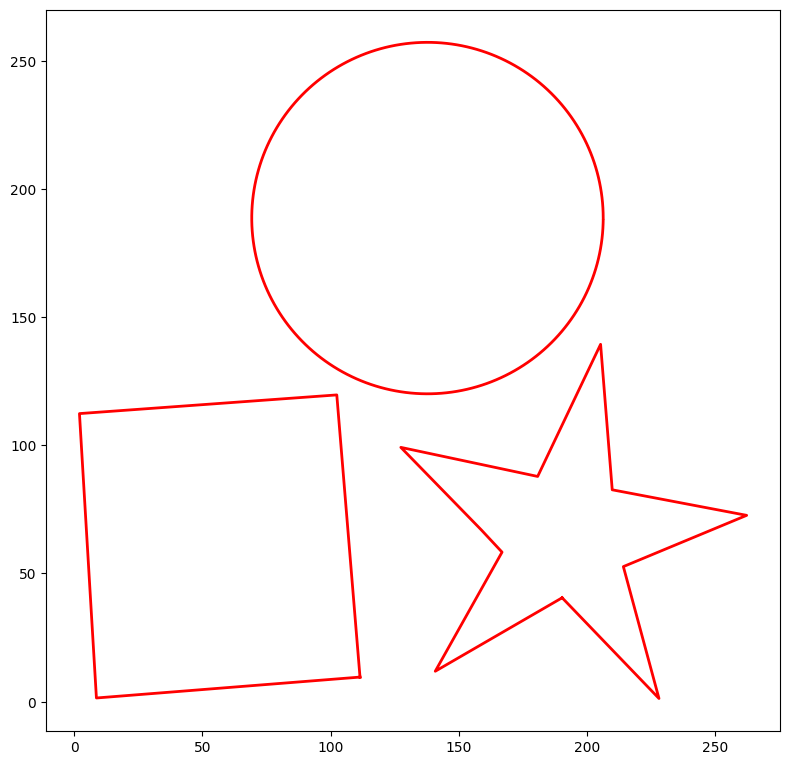

In [ ]:
import numpy as np
import math
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def angle_between_lines_from_points(p1, p2, p3, p4):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p4) - np.array(p3)

    dot_product = np.dot(v1, v2)

    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    theta_radians = np.arccos(cos_theta)
    theta_degrees = np.degrees(theta_radians)

    return theta_degrees

def distance_2d(point1, point2):
    p1 = np.array(point1)
    p2 = np.array(point2)

    distance = np.linalg.norm(p2 - p1)

    return distance

def calculate_slope_intercept(x1, y1, x2, y2):
    if x1 == x2:
        return None, None
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

def find_intersection_from_points(p1, p2, p3, p4):
    x1, y1, x2, y2, x3, y3, x4, y4 = p1[0], p1[1], p2[0], p2[1], p3[0], p3[1], p4[0], p4[1]
    m1, b1 = calculate_slope_intercept(x1, y1, x2, y2)
    m2, b2 = calculate_slope_intercept(x3, y3, x4, y4)

    if m1 is None:
        x = x1
        y = m2 * x + b2
    elif m2 is None:
        x = x3
        y = m1 * x + b1
    elif m1 == m2:
        return None if b1 != b2 else "Infinite intersections (coincident lines)"
    else:
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1

    return (x, y)

def generate_circle_points(cx, cy, r):
    points = []
    num_points = int(2 * math.pi * r)
    for i in range(num_points):
        theta = 2 * math.pi * i / num_points
        x = cx + r * math.cos(theta)
        y = cy + r * math.sin(theta)
        points.append((x, y))
    return points

def process_shape(target_input):
    count = 0
    list_change = []
    points_list = []
    while count < len(target_input) - 2:
        angle = angle_between_lines_from_points(target_input[count], target_input[count + 1], target_input[count + 1], target_input[count + 2])
        if angle > 5:
            list_change.append(angle)
            points_list.append(target_input[count + 1])
        count += 1
    angle = angle_between_lines_from_points(target_input[-2], target_input[-1], target_input[-1], target_input[0])
    if angle > 5:
        list_change.append(angle)
        points_list.append(target_input[-1])

    point_count = 0
    dist_list = []
    while point_count < len(points_list) - 1:
        dist_list.append(distance_2d(points_list[point_count], points_list[point_count + 1]))
        point_count += 1

    dist_list.append(distance_2d(points_list[0], points_list[-1]))

    count_dist = 0
    polygon_point = []
    while count_dist < len(dist_list):
        if dist_list[count_dist] > 10:
            polygon_point.append(points_list[count_dist])
        count_dist += 1

    if len(polygon_point) != 0:
        polygon_point.append(polygon_point[0])
    else:
        x_list = [items[0] for items in target_input]
        y_list = [items[1] for items in target_input]
        p1 = target_input[x_list.index(min(x_list))]
        p2 = target_input[x_list.index(max(x_list))]
        p3 = target_input[y_list.index(min(y_list))]
        p4 = target_input[y_list.index(max(y_list))]

        d1 = distance_2d(p1, p2)
        d2 = distance_2d(p3, p4)

        radius = ((d1 + d2) / 2) / 2
        intersection_point = find_intersection_from_points(p1, p2, p3, p4)

        polygon_point = generate_circle_points(intersection_point[0], intersection_point[1], radius)

        polygon_1 = Polygon(polygon_point)
        polygon_2 = Polygon(target_input)

        intersection = polygon_1.intersection(polygon_2)
        intersection_area = intersection.area
        if intersection_area / polygon_2.area < 0.9:
            pass

    array_2d = [np.array(sublist) for sublist in polygon_point]
    array_2d = np.array(array_2d)
    return array_2d

def plot_combined(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colors = ['r', 'k', 'b']  # Different colors for each shape
    for i, XYs in enumerate(paths_XYs):
        c = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Adjust the file path as necessary
csv_path = 'isolated.csv'
input_path = read_csv(csv_path)
shapes = [input_path[0][0], input_path[1][0], input_path[2][0]]

processed_shapes = [process_shape(shape) for shape in shapes]

plot_combined([processed_shapes])